In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
from glob import glob
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Pilot Data Check

## Load and filter data

In [3]:
data_path = '../data'
eeg_path = f'{data_path}/interim/SIdyads_EEG_pilot'
trial_path = f'{data_path}/raw/SIdyads_trials_pilot'
subj = 'subj003_10182023'
subj_out = subj.split('_')[0]
preproc_file = f'{eeg_path}/{subj}/{subj}_preproc.mat'
trial_files = f'{trial_path}/{subj}/timingfiles/*.csv'
out_dir = f'{data_path}/interim/CleanedEEG/{subj_out}'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [4]:
artifact_trials = loadmat(preproc_file)['idx_badtrial'].squeeze().astype('bool')
trials = []
for run, tf in enumerate(sorted(glob(trial_files))):
    df = pd.read_csv(tf)
    df['run'] = run
    df['run_file'] = tf
    trials.append(df)
trials = pd.concat(trials).reset_index(drop=True)
trials['artifact_trial'] = artifact_trials
n_orig_trials = len(trials)
print(f'original number of trials: {n_orig_trials}')
trials = trials[~trials.artifact_trial]
print(f'number of trials after EEG preprocessing: {len(trials)}')
print(f'percent of trials removed: {np.round(((n_orig_trials - len(trials))/n_orig_trials)*100):.0f}%')

original number of trials: 1925
number of trials after EEG preprocessing: 1691
percent of trials removed: 12%


In [5]:
catch_trials = np.invert(trials.condition.to_numpy().astype('bool'))
response_trials = trials.response.to_numpy().astype('bool')
trial_to_remove = catch_trials + response_trials
trials = trials[~trial_to_remove].reset_index(drop=True)
print(f'number of catch trials plus false alarms: {np.sum(trial_to_remove)}')
print(f'final number of trials: {len(trials)}')
print()
trials.head()

number of catch trials plus false alarms: 169
final number of trials: 1522



,video_name,condition,block,iti,onset_time,offset_time,duration,response,movie_path,run,run_file,artifact_trial
0,yt-1icEOZdgkVY_35.mp4,1,1,1.2,2.016111,2.518062,0.501951,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,../data/raw/SIdyads_trials_pilot/subj003_10182...,False
1,yt-cYECXplgRi4_15.mp4,1,1,1.3,3.716548,4.206679,0.490131,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,../data/raw/SIdyads_trials_pilot/subj003_10182...,False
2,yt-UZjgD-xTz9Q_310.mp4,1,1,1.3,5.516985,6.011039,0.494054,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,../data/raw/SIdyads_trials_pilot/subj003_10182...,False
3,yt-ix0bg7Lgyas_26.mp4,1,1,1.2,7.317525,7.805758,0.488232,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,../data/raw/SIdyads_trials_pilot/subj003_10182...,False
4,flickr-1-6-4-12557575164_3.mp4,1,1,1.3,9.018111,9.509143,0.491032,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,../data/raw/SIdyads_trials_pilot/subj003_10182...,False


In [6]:
data_file = f'{eeg_path}/{subj}/{subj}_trialonly.mat'
data_array = loadmat(data_file)['trl']

# remove catch and false alarm trials
data_array = data_array[np.invert(trial_to_remove), :, :]
print(data_array.shape)

(1522, 63, 276)


In [7]:
trials['video_id'] = pd.factorize(trials['video_name'])[0]
n_sensors = data_array.shape[1]
n_time = data_array.shape[-1]
n_conditions = len(trials.video_id.unique())
print(f'n_sensors = {n_sensors}')
print(f'n_time = {n_time}')
print(f'n_conditions = {n_conditions}')

n_sensors = 63
n_time = 276
n_conditions = 250


## Reliability

In [8]:
grouped_indices = trials.groupby(['video_name']).indices
split_half = np.zeros((len(grouped_indices), 2, n_sensors, n_time))
average_data_array = np.zeros((len(grouped_indices), n_sensors, n_time))
for i, (_, val) in enumerate(grouped_indices.items()):
    split_half[i, 0, :, :] = data_array[val[::2], :, :].mean(axis=0, keepdims=True)
    split_half[i, 1, :, :] = data_array[val[1::2], :, :].mean(axis=0, keepdims=True)
    average_data_array[i, :, :] = data_array[val, :, :].mean(axis=0, keepdims=True)

In [9]:
def corr2d(x, y):
    x_m = x - np.mean(x, axis=0)
    y_m = y - np.mean(y, axis=0)

    numer = np.sum((x_m * y_m), axis=0)
    denom = np.sqrt(np.sum((x_m * x_m), axis=0) * np.sum((y_m * y_m), axis=0))
    denom[denom == 0] = np.nan
    return numer / denom

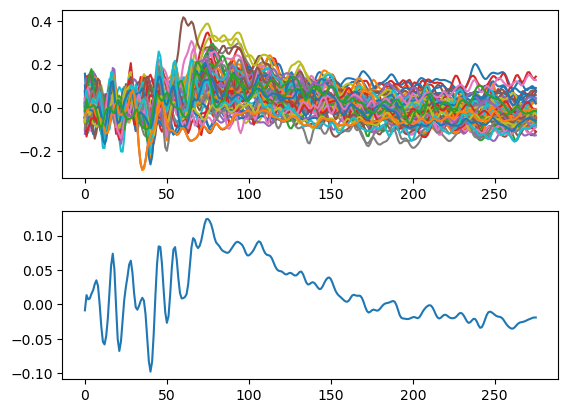

In [10]:
reliability = []
for isample in range(n_time):
    reliability.append(corr2d(split_half[:, 0, :, isample].squeeze(), split_half[:, 1, :, isample].squeeze()))
reliability = np.vstack(reliability)
_, ax = plt.subplots(2)
ax[0].plot(reliability)
ax[1].plot(reliability.mean(axis=-1))
print()

## Pairwise Decoding

In [11]:
import scipy
from sklearn.discriminant_analysis import _cov
from sklearn.svm import LinearSVC
from cv import ShuffleBinLeaveOneOut
from tqdm import tqdm
from itertools import combinations
import time
from joblib import Parallel, delayed

In [12]:
# Parameters
n_perm = 20  # number of permutations
n_pseudo = 4  # number of pseudo-trials

In [13]:
conditions = trials.video_id.to_numpy()
conditions_list = sorted(np.unique(conditions))
conditions_nCk = list(combinations(conditions_list, 2))

sort_indices = np.argsort(conditions)
y = conditions[sort_indices]
X = data_array[sort_indices, ...]
print(f'X shape = {X.shape}')
print(f'y shape = {y.shape}')

X shape = (1522, 63, 276)
y shape = (1522,)


In [14]:
np.random.seed(0)
cv = ShuffleBinLeaveOneOut(y, n_iter=n_perm, n_pseudo=n_pseudo) 
out = {'conditions': conditions_list,
      'conditions_nCk': conditions_nCk,
      'n_sensors': n_sensors,
      'n_conditions': n_conditions,
      'n_time': n_time,
      'n_perm': n_perm,
      'n_pseudo': n_pseudo,
      'X': X,
      'y': y,
      'train_indices': [],
      'test_indices': [],
      'permutation_number': 0,
      'labels_pseudo_train': [],
      'labels_pseudo_test': [],
      'ind_pseudo_train': [],
      'ind_pseudo_test': []}
for f, (train_indices, test_indices) in enumerate(cv.split(X)):
    out['permutation_number'] = f
    out['train_indices'] = train_indices
    out['test_indices'] = train_indices
    out['labels_pseudo_train'] = cv.labels_pseudo_train
    out['labels_pseudo_test'] = cv.labels_pseudo_test
    out['ind_pseudo_train'] = cv.ind_pseudo_train
    out['ind_pseudo_test'] = cv.ind_pseudo_test
    np.savez(f'../data/interim/CleanedEEG/{subj_out}/data4rdms_perm-{str(f).zfill(2)}.npz', **out)